In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle

import sys
sys.path.append('../../')
import ndrought.drought_network as dnet

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
usdm_net = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/USDM_net_f25k_d1_rt20p_paired.pickle')

In [3]:
spi30d_net = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/spi_30d_net_f25k_d1_rt20p_paired.pickle')

In [4]:
spi180d_net = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/spi_180d_net_f25k_d1_rt20p_paired.pickle')

In [5]:
matched_dates_dict = {i:i for i in np.arange(1149)}

In [6]:
usdm_spi30d_oe = usdm_net.find_overlapping_nodes_events(spi30d_net, matched_dates_dict)

Overlapping USDM Drought Network & SPI_30D Drought Network:   0%|          | 0/4103268 [00:00<?, ?it/s]

In [7]:
usdm_spi180d_oe = usdm_net.find_overlapping_nodes_events(spi180d_net, matched_dates_dict)

Overlapping USDM Drought Network & SPI_180D Drought Network:   0%|          | 0/3501020 [00:00<?, ?it/s]

In [8]:
spi30d_spi180d_oe = spi30d_net.find_overlapping_nodes_events(spi180d_net, matched_dates_dict)

Overlapping SPI_30D Drought Network & SPI_180D Drought Network:   0%|          | 0/4365660 [00:00<?, ?it/s]

In [9]:
def compute_alignment_area(overlap_events):
    """Computes the alignment fraction, AA.

    Parameters
    ----------
    overlap_events
        Output from find_overlapping_nodes_events.
    
    Returns
    -------
    list[dict]
        Elements within the list are threads, dictionaries
        that map DroughtNetwork time to respective AA values.
    
    """
    net_aa = []

    for thread in overlap_events:
        thread_aa = dict()

        for event in thread:
            time = list(event.keys())[0]

            event_a = np.array(event[time])[:, 0]
            coords_a = np.vstack([node.coords for node in event_a])
            coord_set_a = set(tuple(coord) for coord in coords_a)

            event_b = np.array(event[time])[:, 1]
            coords_b = np.vstack([node.coords for node in event_b])
            coord_set_b = set(tuple(coord) for coord in coords_b)

            coord_set_intersect = coord_set_a.intersection(coord_set_b)

            thread_aa[time] = len(coord_set_intersect)
    
        net_aa.append(thread_aa)

    return net_aa

In [10]:
def compute_disagreement_area(a_net, b_net, overlap_events):
    """
    
    Parameters
    ----------
    a_net: DroughtNetwork
    b_net: DroughtNetwork
    overlap_events
        Output from find_overlapping_nodes_events.
    
    Returns
    -------
    dict, dict
    
    """
    a_overlapped = dict()
    b_overlapped = dict()
    times = []

    for thread in overlap_events:
        for event in thread: 
            time = list(event.keys())[0]

            if not time in a_overlapped.keys():
                a_overlapped[time] = []
            if not time in b_overlapped.keys():
                b_overlapped[time] = []

            event_a = np.array(event[time])[:, 0]
            event_b = np.array(event[time])[:, 1]
            times.append(time)

            a_overlapped[time].extend(np.hstack(event_a))
            b_overlapped[time].extend(np.hstack(event_b))

    a_nodes = dict()
    b_nodes = dict()

    a_not_overlapped = dict()
    b_not_overlapped = dict()

    for node in a_net.nodes:
        time = node.time
        
        if not time in a_nodes.keys():
            a_nodes[time] = []
        a_nodes[time].append(node)

        if not time in a_overlapped.keys() or not node in a_overlapped[time]:
            if time not in a_not_overlapped.keys():
                a_not_overlapped[time] = []
            a_not_overlapped[time].append(node)

    for node in b_net.nodes:
        time = node.time

        if not time in b_nodes.keys():
            b_nodes[time] = []
        b_nodes[time].append(node)

        if not time in b_overlapped.keys() or not node in b_overlapped[time]:
            if time not in b_not_overlapped.keys():
                b_not_overlapped[time] = []
            b_not_overlapped[time].append(node)

    a_df = dict()
    b_df = dict()

    for time in a_not_overlapped.keys():
        all_nodes = a_nodes[time]
        not_overlapped_nodes = a_not_overlapped[time]

        total_area = 0
        not_overlapped_area = 0

        for node in not_overlapped_nodes:
            not_overlapped_area += len(node.coords)
        for node in all_nodes:
            total_area += len(node.coords)

        a_df[time] = not_overlapped_area

    for time in b_not_overlapped.keys():
        all_nodes = b_nodes[time]
        not_overlapped_nodes = b_not_overlapped[time]

        total_area = 0
        not_overlapped_area = 0

        for node in not_overlapped_nodes:
            not_overlapped_area += len(node.coords)
        for node in all_nodes:
            total_area += len(node.coords)

        b_df[time] = not_overlapped_area

    return a_df, b_df

In [11]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

In [12]:
times = paired_ds['USDM Date'].values

In [13]:
area_scalar = 18.1 # km2

In [14]:
usdm_spi30d_aa = compute_alignment_area(usdm_spi30d_oe)

In [15]:
usdm_spi30d_da, spi30d_usdm_da = compute_disagreement_area(usdm_net, spi30d_net, usdm_spi30d_oe)

Text(0.5, 0, 'time')

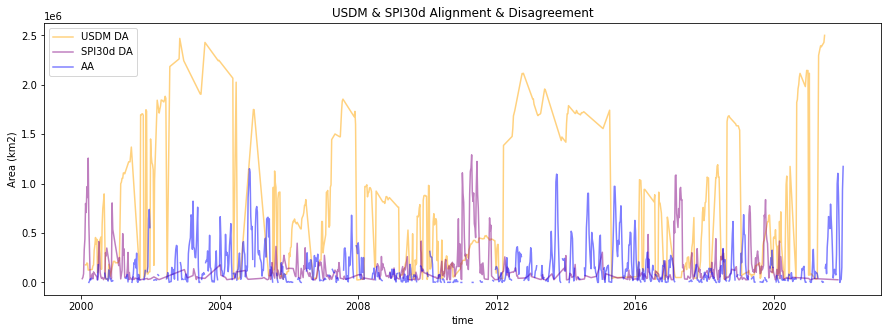

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(usdm_spi30d_da.keys())], np.array(list(usdm_spi30d_da.values()))*area_scalar, color='orange', alpha=0.5, label='USDM DA')
ax.plot(times[list(spi30d_usdm_da.keys())], np.array(list(spi30d_usdm_da.values()))*area_scalar, color='purple', alpha=0.5, label='SPI30d DA')

for i, aa in enumerate(usdm_spi30d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('USDM & SPI30d Alignment & Disagreement')
ax.set_xlabel('time')

In [17]:
usdm_spi180d_aa = compute_alignment_area(usdm_spi180d_oe)

In [18]:
usdm_spi180d_da, spi180d_usdm_da = compute_disagreement_area(usdm_net, spi180d_net, usdm_spi180d_oe)

Text(0.5, 0, 'time')

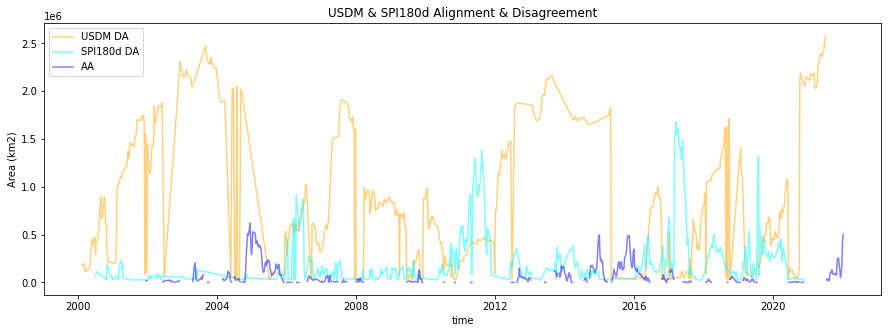

In [19]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(usdm_spi180d_da.keys())], np.array(list(usdm_spi180d_da.values()))*area_scalar, color='orange', alpha=0.5, label='USDM DA')
ax.plot(times[list(spi180d_usdm_da.keys())], np.array(list(spi180d_usdm_da.values()))*area_scalar, color='cyan', alpha=0.5, label='SPI180d DA')

for i, aa in enumerate(usdm_spi180d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('USDM & SPI180d Alignment & Disagreement')
ax.set_xlabel('time')

In [20]:
spi30d_spi180d_aa = compute_alignment_area(spi30d_spi180d_oe)

In [21]:
spi30d_spi180d_da, spi180d_spi30d_da = compute_disagreement_area(spi30d_net, spi180d_net, usdm_spi180d_oe)

Text(0.5, 0, 'time')

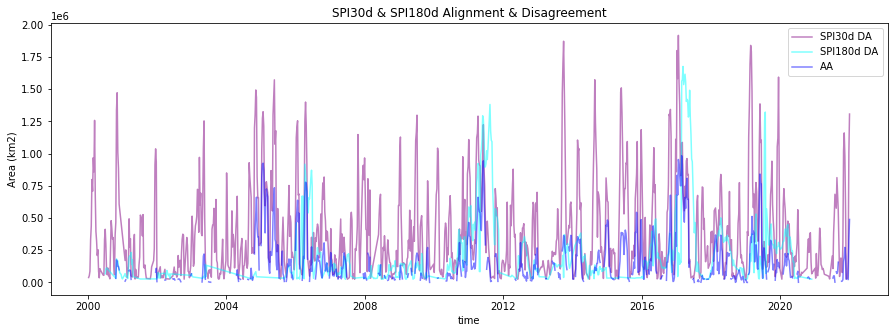

In [22]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(spi30d_spi180d_da.keys())], np.array(list(spi30d_spi180d_da.values()))*area_scalar, color='purple', alpha=0.5, label='SPI30d DA')
ax.plot(times[list(spi180d_spi30d_da.keys())], np.array(list(spi180d_spi30d_da.values()))*area_scalar, color='cyan', alpha=0.5, label='SPI180d DA')

for i, aa in enumerate(spi30d_spi180d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('SPI30d & SPI180d Alignment & Disagreement')
ax.set_xlabel('time')

## Pull out case studies

### 2015

(16314.0, 17075.0)

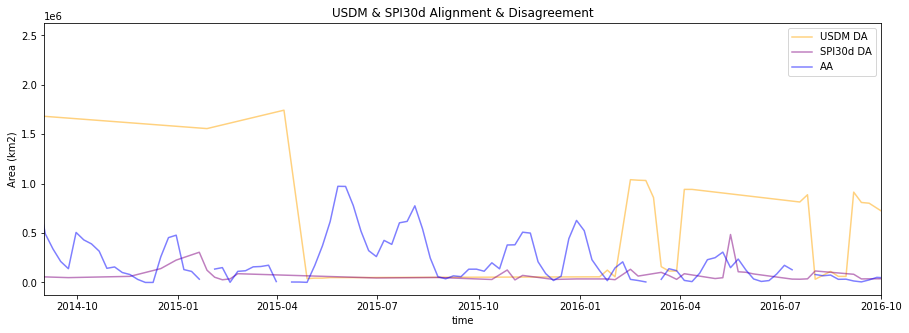

In [28]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(usdm_spi30d_da.keys())], np.array(list(usdm_spi30d_da.values()))*area_scalar, color='orange', alpha=0.5, label='USDM DA')
ax.plot(times[list(spi30d_usdm_da.keys())], np.array(list(spi30d_usdm_da.values()))*area_scalar, color='purple', alpha=0.5, label='SPI30d DA')

for i, aa in enumerate(usdm_spi30d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('USDM & SPI30d Alignment & Disagreement')
ax.set_xlabel('time')

ax.set_xlim('2014-09', '2016-10')

(16314.0, 17075.0)

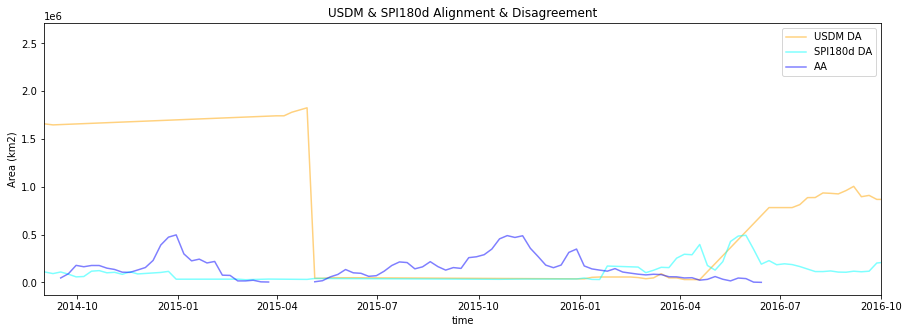

In [27]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(usdm_spi180d_da.keys())], np.array(list(usdm_spi180d_da.values()))*area_scalar, color='orange', alpha=0.5, label='USDM DA')
ax.plot(times[list(spi180d_usdm_da.keys())], np.array(list(spi180d_usdm_da.values()))*area_scalar, color='cyan', alpha=0.5, label='SPI180d DA')

for i, aa in enumerate(usdm_spi180d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('USDM & SPI180d Alignment & Disagreement')
ax.set_xlabel('time')

ax.set_xlim('2014-09', '2016-10')

(16314.0, 17075.0)

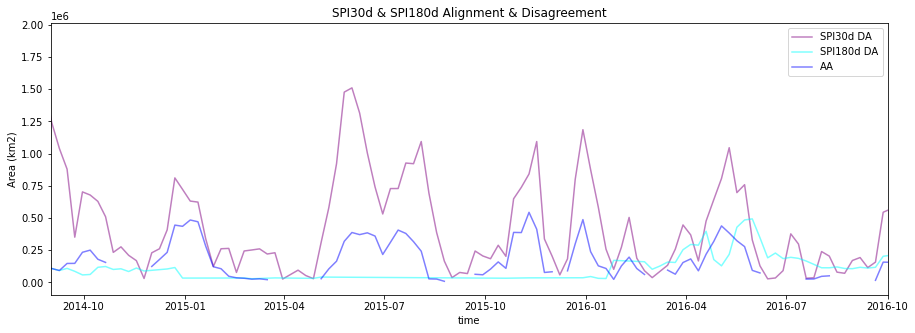

In [26]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times[list(spi30d_spi180d_da.keys())], np.array(list(spi30d_spi180d_da.values()))*area_scalar, color='purple', alpha=0.5, label='SPI30d DA')
ax.plot(times[list(spi180d_spi30d_da.keys())], np.array(list(spi180d_spi30d_da.values()))*area_scalar, color='cyan', alpha=0.5, label='SPI180d DA')

for i, aa in enumerate(spi30d_spi180d_aa):
    if i == 0:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5, label='AA')
    else:
        ax.plot(times[list(aa.keys())], np.array(list(aa.values()))*area_scalar, color='b', alpha=0.5)

ax.legend()
ax.set_ylabel('Area (km2)')
fig.set_facecolor('w')
ax.set_title('SPI30d & SPI180d Alignment & Disagreement')
ax.set_xlabel('time')

ax.set_xlim('2014-09', '2016-10')